In [254]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import common

In [255]:
finn_dir = Path("../data_out/langmuir/default_finn_251")

In [256]:
config = json.loads((finn_dir / "input.json").read_text())
config

{'y_train_path': 'data/FINN_forward_solver/retardation_langmuir/c_train.npy',
 'output_dir': 'data_out/langmuir/default_finn_251',
 'train_split_idx': 251,
 'max_epochs': 100,
 'seed': 87364854,
 'c_field_seed': None,
 'dropout': 0}

In [257]:
analytical_retardation_type = Path(config["output_dir"]).parts[1]
analytical_retardation_type

'langmuir'

In [258]:
analytical_ret = np.load(finn_dir / f"retardation_{analytical_retardation_type}.npy")#.ravel()
analytical_ret.shape

(100, 1)

In [259]:
# loss_mse = np.loadtxt(finn_dir / "loss_mse.txt")
# loss_phys = np.loadtxt(finn_dir / "loss_phys.txt")
loss = np.loadtxt(finn_dir / "loss.txt")
len(loss)

13

In [260]:
file_df = {
    "loss": [],
    "epoch": [],
    "ret_path": [],
    "c_train_pred_path": [],
}

for epoch in range(1, len(loss) + 1):
    file_df["loss"].append(loss[epoch-1])
    file_df["epoch"].append(epoch)
    ret_path = finn_dir / f"predicted_retardations/retPred_{epoch}.npy"
    file_df["ret_path"].append(ret_path if ret_path.exists() else None)
    c_train_pred_path = finn_dir / f"predicted_concentrations/c_pred_{epoch}.npy"
    file_df["c_train_pred_path"].append(c_train_pred_path if c_train_pred_path.exists() else None)

file_df = pd.DataFrame(file_df)

## Compute MSE

In [261]:
file_df["MSE(c_train_pred, c_train)"] = file_df["c_train_pred_path"].apply(
    lambda p: np.square(np.load(p) - np.load(p.parent.parent / "c_train.npy")).mean()
)
file_df["MSE(ret_pred, ret_analytical)"] = file_df["ret_path"].apply(
    lambda p: np.square(np.load(p) - analytical_ret).mean()
)
display(file_df.dtypes)
display(len(file_df))
display(file_df.head())
# display(file_df)

loss                             float64
epoch                              int64
ret_path                          object
c_train_pred_path                 object
MSE(c_train_pred, c_train)       float32
MSE(ret_pred, ret_analytical)    float32
dtype: object

13

,loss,epoch,ret_path,c_train_pred_path,"MSE(c_train_pred, c_train)","MSE(ret_pred, ret_analytical)"
0,37.519253,1,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.002830,0.861914
1,29.764467,2,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.002259,0.754300
2,13.047176,3,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.001000,0.296119
3,7.454958,4,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.000571,0.140837
4,7.447062,5,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.000571,0.140798


### MSE of full field

In [262]:
c_train = np.load(finn_dir / "c_train.npy")
c_train_pred = np.load(finn_dir / "c_train_predictions.npy")
c_full = np.load(finn_dir / "c_full.npy")
c_full_pred = np.load(finn_dir / "c_full_predictions.npy")
print(f"MSE(c_train, c_train_pred) = {np.square(c_train - c_train_pred).mean():.2e}")
print(f"MAE(c_train, c_train_pred) = {np.abs(c_train - c_train_pred).max():.2e}")
print(f"MSE(c_full, c_full_pred) = {np.square(c_full - c_full_pred).mean():.2e}")
print(f"MAE(c_full, c_full_pred) = {np.abs(c_full - c_full_pred).max():.2e}")

FileNotFoundError: [Errno 2] No such file or directory: '../data_out/langmuir/default_finn_251/c_train_predictions.npy'

## Visualize Loss and MSE

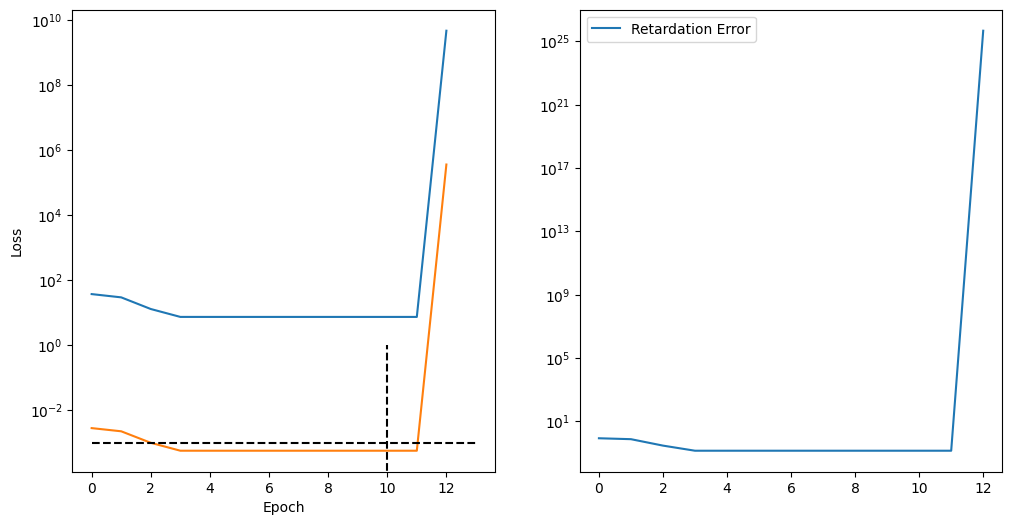

In [263]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
# ax.semilogy(loss_mse, label="MSE Loss")
# ax.semilogy(loss_phys, label="Physical Loss")
ax1.semilogy(file_df["loss"], label="Total Loss")
ax1.semilogy(file_df["MSE(c_train_pred, c_train)"], label="MSE")
ax1.vlines(10, 0, 1, color="k", linestyle="--")  # just a random marker
ax1.hlines(1e-3, 0, len(loss), color="k", linestyle="--")  # just a random marker
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.semilogy(file_df["MSE(ret_pred, ret_analytical)"], label="Retardation Error")
# ax2.semilogy(analytical_ret, label=analytical_retardation_type.capitalize())
ax2.legend()
plt.show()

In [264]:
ret_df = file_df.copy()
ret_df["ret"] = ret_df["ret_path"].apply(lambda p: np.load(p).ravel())
ret_df = ret_df.explode("ret").reset_index(drop=True)
ret_df["u"] = np.tile(np.arange(0, 100), len(file_df))
ret_df["ret"] = ret_df["ret"].astype(np.float64)

In [265]:
ret_df

,loss,epoch,ret_path,c_train_pred_path,"MSE(c_train_pred, c_train)","MSE(ret_pred, ret_analytical)",ret,u
0,3.751925e+01,1,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.00283,8.619137e-01,2.732227e+00,0
1,3.751925e+01,1,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.00283,8.619137e-01,2.732764e+00,1
2,3.751925e+01,1,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.00283,8.619137e-01,2.733301e+00,2
3,3.751925e+01,1,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.00283,8.619137e-01,2.733838e+00,3
4,3.751925e+01,1,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,0.00283,8.619137e-01,2.734373e+00,4
...,...,...,...,...,...,...,...,...
1295,4.739360e+09,13,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,363113.71875,4.696010e+25,2.246704e+12,95
1296,4.739360e+09,13,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,363113.71875,4.696010e+25,2.197012e+12,96
1297,4.739360e+09,13,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,363113.71875,4.696010e+25,2.149428e+12,97
1298,4.739360e+09,13,../data_out/langmuir/default_finn_251/predicte...,../data_out/langmuir/default_finn_251/predicte...,363113.71875,4.696010e+25,2.103614e+12,98


In [266]:
ret_df["loss_split"] = ["left" if loss < 1e-2 else "right" for loss in ret_df["loss"]]

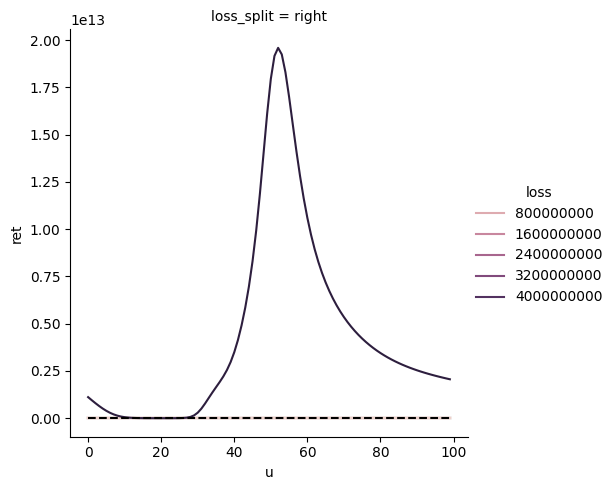

In [267]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="loss",
    col="loss_split",
)

for ax in g.axes.flat:
    ax.plot(analytical_ret, "k--")
    if analytical_retardation_type == "freundlich":
        ax.set_ylim(3, 5)
plt.show()